![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FModel+Monitoring&file=bqml-model-monitoring-tutorial.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Model%20Monitoring/bqml-model-monitoring-tutorial.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FModel%2520Monitoring%2Fbqml-model-monitoring-tutorial.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Model%20Monitoring/bqml-model-monitoring-tutorial.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Model%20Monitoring/bqml-model-monitoring-tutorial.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# BigQuery ML (BQML) - Model Monitoring Tutorial

---
TODO:
- [ ] Write Overview for this notebook that matches the blog post
- [ ] link to blog post
- [ ] link to introduction notebook
- [ ] links for the new functions:
    - [ ] search for 'link here' and add links throughout
    
Questions/Choices:
- this has moved from tutorial to full workshop - ok? or think about splitting up into segments?
- removed transform only model, may still show monitoring transformed and raw values
- removed history table for feature management - another notebook based workflow!
---



---
## Colab Setup

When running this notebook in [Colab](https://colab.google/) or [Colab Enterprise](https://cloud.google.com/colab/docs/introduction), this section will authenticate to GCP (follow prompts in the popup) and set the current project for the session.

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user(project_id = PROJECT_ID)
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('tensorflow_data_validation', 'tensorflow-data-validation'),
    ('tensorflow_metadata', 'tensorflow-metadata')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

---
## Setup

Packages:

In [4]:
import json

Clients:

In [5]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Prepare the code below for your environment.

This notebook takes advantage of the [BigQuery IPython magic](https://cloud.google.com/python/docs/reference/bigquery/latest/magics) for legibility and ease of copy/pasting to BigQuery SQL editor.  If this notebook is being used from an environment that can run notebooks it needs further preparation: Colab, Colab Enterprise, Vertex AI Workbench Instances, or BigQuery Studio with a Python Notebook.  The SQL code in these cells uses the fully qualified [BigQuery table](https://cloud.google.com/bigquery/docs/tables-intro) names in the form `projectname.datasetname.tablename`.  Prepare for your environment by:
- Edit > Find
    - Find: `statmike-mlops-349915`
    - Replace: `<your project id>`
    - Replace All

---
## BigQuery Source Data

This project will uses the following data source as a tutorial.  It is good for examples like this because it is small, has few columns, but contains categorial and numerical data types.

The source table is a BigQuery Public Dataset table.  The following cell uses the [BigQuery IPython magic](https://cloud.google.com/python/docs/reference/bigquery/latest/magics) to retrieve 5 rows of the table for review.  This data is known as [Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/) data: 

```
@Manual{,
  title = {palmerpenguins: Palmer Archipelago (Antarctica) penguin data},
  author = {Allison Marie Horst and Alison Presmanes Hill and Kristen B Gorman},
  year = {2020},
  note = {R package version 0.1.0},
  doi = {10.5281/zenodo.3960218},
  url = {https://allisonhorst.github.io/palmerpenguins/},
}
```


There are 334 observations of 4 numerical features (culman length, culmen depth, flipper length, body mass) and 2  categorical features (island, sex) that represent 3 species of penguins.

In [6]:
%%bigquery
SELECT *
FROM `bigquery-public-data.ml_datasets.penguins`
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie Penguin (Pygoscelis adeliae),Dream,36.6,18.4,184.0,3475.0,FEMALE
1,Adelie Penguin (Pygoscelis adeliae),Dream,39.8,19.1,184.0,4650.0,MALE
2,Adelie Penguin (Pygoscelis adeliae),Dream,40.9,18.9,184.0,3900.0,MALE
3,Chinstrap penguin (Pygoscelis antarctica),Dream,46.5,17.9,192.0,3500.0,FEMALE
4,Adelie Penguin (Pygoscelis adeliae),Dream,37.3,16.8,192.0,3000.0,FEMALE


---
## **Goal: Train, Serve, And Monitor A Model**

**Train A Model**

In this workflow our goal is to train and operationalize a machine leanring model that can classify unidentified penguins into the correct `species` using only measurements (`culmen_length_mm`, `culmen_depth_mm`, `flipper_length_mm`, `body_mass_g`), location (`island`) and gender (`sex`).  That means serving predictions, monitoring features, and potentially retraining the model.

**Operationalize The Model**

Taking a trained model to production introduces challenges. The model needs to be regularly evaluated to understand it's performance once put into production. This can be challenging as actual values used to assess the accuracy of predictions may arrive later than the predictions. Continuous monitoring bridges this gap with early signals in two key ways. First, monitoring the distributions of each of the models features for shift (called **skew**) from the training data to the current data. Then, also monitoring for any gradual **drift** in the distribution over time. Setting thresholds and getting alerts for features on each of this distribution changes gives early signals that the model needs to be carefully considered for evaluation and re-training to ensure effectiveness. If the evaluation can be automated then this can even extend to **continuous training**. 

---
## Data Preparation

### Understand The Data Source With `ML.DESCRIBE_DATA`

Reviewing a few records, like above, gives a good sense of how the data is arranged. Before proceeding with machine learning techniques it is important to understand more about these raw columns.  Are they ready to use a features in a model or is some form of feature engineering needed first?  For this, the distribution of values is an important starting point.  

While SQL could be used to look at the distribution, it would be a time consuming process and requires different techniques for different data types like numerical, string, boolean, dates, times, array and struct version of these, and arrays of structs.

To make this process fast and simple, the new [`ML.DESCRIBE_DATA`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-describe-data)

function is used to get a single row for each column the describes the data distribution:

In [8]:
%%bigquery
SELECT *
FROM ML.DESCRIBE_DATA(
  TABLE `bigquery-public-data.ml_datasets.penguins`
)

Query is running:   0%|          |

Downloading:   0%|          |

,name,num_rows,num_nulls,num_zeros,min,max,mean,stddev,median,quantiles,unique,avg_string_length,num_values,top_values,min_array_length,max_array_length,avg_array_length,total_array_length,array_length_quantiles,dimension
0,body_mass_g,344,2,0,2700,6300,4201.754386,800.781229,4000.0,"[2700.0, 4000.0, 6300.0]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
1,culmen_depth_mm,344,2,0,13.1,21.5,17.151170,1.971904,17.3,"[13.1, 17.3, 21.5]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
2,culmen_length_mm,344,2,0,32.1,59.6,43.921930,5.451596,44.1,"[32.1, 44.1, 59.6]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
3,flipper_length_mm,344,2,0,172,231,200.915205,14.041141,197.0,"[172.0, 197.0, 231.0]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
4,island,344,0,<NA>,Biscoe,Torgersen,NaN,NaN,NaN,[],3,6.093023,344,"[{'value': 'Biscoe', 'count': 168}]",<NA>,<NA>,NaN,<NA>,[],<NA>
5,sex,344,10,<NA>,.,MALE,NaN,NaN,NaN,[],3,4.979042,334,"[{'value': 'MALE', 'count': 168}]",<NA>,<NA>,NaN,<NA>,[],<NA>
6,species,344,0,<NA>,Adelie Penguin (Pygoscelis adeliae),Gentoo penguin (Pygoscelis papua),NaN,NaN,NaN,[],3,35.465116,344,[{'value': 'Adelie Penguin (Pygoscelis adeliae...,<NA>,<NA>,NaN,<NA>,[],<NA>


Some observations:
- All columns have `num_rows` and `num_nulls`
- Numerical columns have `min`, `max`, `stddev`, `median`, and `quantiles` showing the distribution of the data in the column
- Categorical (string) columns have `min`, `max` values representing the class levels and a `unique` column show how many class levels

Data quality observation:
- The column `sex` has both missing values (10 indicated in `num_nulls`) as well as a `min` values of `.`.  This appears to be a data quality issue that needs fixing.

### Create A BigQuery Dataset

Create a new [BigQuery Dataset](https://cloud.google.com/bigquery/docs/datasets) as a working location for this workflow:

In [9]:
%%bigquery
CREATE SCHEMA IF NOT EXISTS `statmike-mlops-349915.bqml_model_monitoring`
    OPTIONS(
        location = 'US'
    )

Query is running:   0%|          |

""


### Prepare The Source Data

Make a copy of the table source in the new BigQuery dataset with fixes applied to the data quality issue identified for the `sex` column with values of `.`.

> Note: A copy is being made in this case because the source project is `bigquery-public` which is not editable.

In [10]:
%%bigquery
CREATE OR REPLACE TABLE `statmike-mlops-349915.bqml_model_monitoring.source` AS
    SELECT * EXCEPT(sex),
        CASE WHEN sex = '.' THEN NULL ELSE sex END AS sex
    FROM `bigquery-public-data.ml_datasets.penguins`

Query is running:   0%|          |

""


### Split The Data

Depending on the ML technique, it may be desired to split the data into partitions for training, evaluation, and testing (in this case monitoring examples). 

The following cell creates a version with a new column column named `splits` with values [`TRAIN`, `EVAL`, `TEST`].  The data is first grouped by (stratified) the values of `species` and `island` to preserve any imbalance across the groups. 

In [11]:
%%bigquery
CREATE OR REPLACE TABLE `statmike-mlops-349915.bqml_model_monitoring.source_split` AS
    WITH
        # randomized numbering within groups (species, island)
        RANDOM AS (
            SELECT *,
                ROW_NUMBER() OVER (PARTITION BY species, island ORDER BY RAND()) AS sequence
            FROM `statmike-mlops-349915.bqml_model_monitoring.source`
        ),
        # get group sizes
        GROUP_SIZES AS (
            SELECT species, island, COUNT(*) AS count
            FROM `statmike-mlops-349915.bqml_model_monitoring.source`
            GROUP BY species, island
        )
    SELECT
        * EXCEPT(sequence, count),
        CASE
            WHEN sequence <= CEIL(.2 * count) AND species is not Null THEN 'TEST'
            WHEN sequence <= CEIL(.3 * count) THEN 'EVAL'
            ELSE 'TRAIN'
        END AS splits
    FROM RANDOM
    LEFT OUTER JOIN GROUP_SIZES USING(species, island)

Query is running:   0%|          |

""


Review the data by `splits`:

In [12]:
%%bigquery
SELECT species, island,
    COUNT(*) as count,
    100 * COUNTIF(splits = 'TRAIN')/COUNT(*) AS TRAIN_PCT,
    100 * COUNTIF(splits = 'EVAL')/COUNT(*) AS EVAL_PCT,
    100 * COUNTIF(splits = 'TEST')/COUNT(*) AS TEST_PCT
FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
GROUP BY species, island

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,count,TRAIN_PCT,EVAL_PCT,TEST_PCT
0,Adelie Penguin (Pygoscelis adeliae),Dream,56,69.642857,8.928571,21.428571
1,Chinstrap penguin (Pygoscelis antarctica),Dream,68,69.117647,10.294118,20.588235
2,Gentoo penguin (Pygoscelis papua),Biscoe,124,69.354839,10.483871,20.161290
3,Adelie Penguin (Pygoscelis adeliae),Biscoe,44,68.181818,11.363636,20.454545
4,Adelie Penguin (Pygoscelis adeliae),Torgersen,52,69.230769,9.615385,21.153846


### Review the Training Split With: `ML.DESCRIBE_DATA`

Use [`ML.DESCRIBE_DATA`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-describe-data) to first review the training split of the source data.  This time, some of the additional parameters of the function are useful:
- `top_k`: get the top 3 most frequent categories for string columns (default = 1)
- `num_quantiles`: get 4 quantiles for numerical columns (default = 2)

In [13]:
%%bigquery
SELECT *
FROM ML.DESCRIBE_DATA(
    (
        SELECT * EXCEPT(splits)
        FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
        WHERE splits = 'TRAIN'
    ),
    STRUCT(3 AS top_k, 4 AS num_quantiles)
)

Query is running:   0%|          |

Downloading:   0%|          |

,name,num_rows,num_nulls,num_zeros,min,max,mean,stddev,median,quantiles,unique,avg_string_length,num_values,top_values,min_array_length,max_array_length,avg_array_length,total_array_length,array_length_quantiles,dimension
0,body_mass_g,238,1,0,2850,6300,4228.586498,805.926627,4000.0,"[2850.0, 3600.0, 4050.0, 4800.0, 6300.0]",<NA>,NaN,237,[],<NA>,<NA>,NaN,<NA>,[],<NA>
1,culmen_depth_mm,238,1,0,13.1,21.1,17.172152,1.948164,17.3,"[13.1, 15.6, 17.3, 18.7, 21.1]",<NA>,NaN,237,[],<NA>,<NA>,NaN,<NA>,[],<NA>
2,culmen_length_mm,238,1,0,32.1,59.6,43.999578,5.422064,44.5,"[32.1, 39.6, 44.5, 48.7, 59.6]",<NA>,NaN,237,[],<NA>,<NA>,NaN,<NA>,[],<NA>
3,flipper_length_mm,238,1,0,176,231,201.611814,14.093762,197.0,"[176.0, 190.0, 197.0, 215.0, 231.0]",<NA>,NaN,237,[],<NA>,<NA>,NaN,<NA>,[],<NA>
4,island,238,0,<NA>,Biscoe,Torgersen,NaN,NaN,NaN,[],3,6.092437,238,"[{'value': 'Biscoe', 'count': 116}, {'value': ...",<NA>,<NA>,NaN,<NA>,[],<NA>
5,sex,238,10,<NA>,FEMALE,MALE,NaN,NaN,NaN,[],2,4.921053,228,"[{'value': 'MALE', 'count': 123}, {'value': 'F...",<NA>,<NA>,NaN,<NA>,[],<NA>
6,species,238,0,<NA>,Adelie Penguin (Pygoscelis adeliae),Gentoo penguin (Pygoscelis papua),NaN,NaN,NaN,[],3,35.462185,238,[{'value': 'Adelie Penguin (Pygoscelis adeliae...,<NA>,<NA>,NaN,<NA>,[],<NA>


---
## Model Training

Create a model trained to classify `species` for the traning records.  Here, directly in BigQuery, the [`CREATE MODEL` statement for deep neural network (DNN) models](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-dnn-models) is used.  This uses the `TRANSFORM` clause within the model to embed user specified transfomations within the model for use during serving and model monitoring which will both be show later in this introduction.

> Note: This runs for about 15-16 minutes

From reviewing the training data above, the following transformations will be tried:
- Apply [`ML.ROBUST_SCALER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-robust-scaler) to `body_mass_g`
- Apply [`ML.STANDARD_SCALER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-standard-scaler) to `culmen_depth_mm` and `culmen_length_mm`
- Apply [`ML.QUANTILE_BUCKATIZE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-quantile-bucketize) to `flipper_length_mm`
- Apply [`ML.IMPUTER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-imputer) to `island`, and `sex`

In [14]:
%%bigquery
CREATE MODEL IF NOT EXISTS `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`
    TRANSFORM(
        ML.ROBUST_SCALER(body_mass_g) OVER() AS body_mass_g,
        ML.STANDARD_SCALER(culmen_length_mm) OVER() AS culmen_length_mm,
        ML.STANDARD_SCALER(culmen_depth_mm) OVER() AS culmen_depth_mm,
        ML.QUANTILE_BUCKETIZE(flipper_length_mm, 3) OVER() AS flipper_length_mm,
        ML.IMPUTER(sex, 'most_frequent') OVER() AS sex,
        ML.IMPUTER(island, 'most_frequent') OVER() AS island,
        species, split
    )
    OPTIONS(
        MODEL_TYPE = 'DNN_CLASSIFIER',
        INPUT_LABEL_COLS = ['species'],
        
        # data specifics
        DATA_SPLIT_METHOD = 'CUSTOM',
        DATA_SPLIT_COL = 'split',
        
        # model specifics
        AUTO_CLASS_WEIGHTS = TRUE,
        HIDDEN_UNITS = [128, 128, 128]
    )
AS
    SELECT * EXCEPT(splits),
        CASE WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE END AS split
    FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
    WHERE splits != 'TEST'

Query is running:   0%|          |

""


In [18]:
%%bigquery history
SELECT *
FROM ML.TRAINING_INFO(MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`)
ORDER BY iteration

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='iteration'>

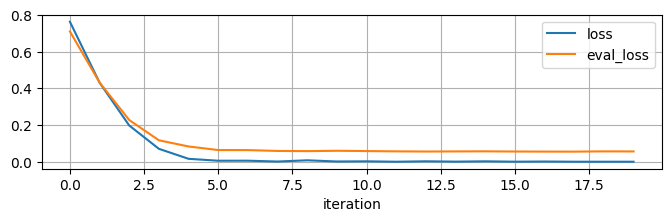

In [19]:
history.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (8, 2), grid = True)

<Axes: xlabel='iteration'>

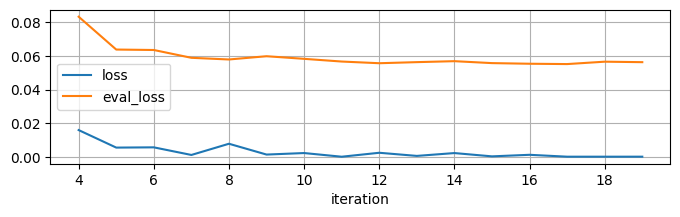

In [20]:
history.iloc[4:].plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (8, 2), grid = True)

### Evaluation With `ML.EVALUATE`

BigQuery ML models can be directly evaluated with the [`ML.EVALUATE` function](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate).  The evaluation of the model on evaluation data specified during training can be done by just specifying the model.  To evaluate the model on new data, like a `TEST` split or even the `TRAIN` split, the records can be specified with a query statement as seen in the following evaluations.

> An evaluation split with 10% of records was created above.  This set would normally be used for tuning model hyperparameters, like `BATCH_SIZE`, `DROPOUT`, `HIDDEN_UNITS`, `LEARN_RATE`, and/or `OPTIMIZER` in the case of the DNN used here.  This could also be done directly in the BigQuery `CREATE MODEL` statement with [hyperparameter tuning](https://cloud.google.com/bigquery/docs/hp-tuning-overview).

In [21]:
%%bigquery
SELECT *
FROM ML.EVALUATE (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`
)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.936111,0.952137,0.942857,0.942222,0.122203,0.999218


### Evaluate The Model: Training Data Split (`TRAIN`)

Evaluating the model on the training data is good for setting a baseline for the likely best possible performance of the model.  

In [22]:
%%bigquery
SELECT *
FROM ML.EVALUATE (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
        WHERE splits = 'TRAIN'
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1.0,1.0,1.0,1.0,0.000526,1.0


### Evaluate The Model: `TEST` Data Split

Evaluating the model on the `TEST` split is a good gauge of performance in general as it represents data the model was not exposed to during training: 

In [23]:
%%bigquery
SELECT *
FROM ML.EVALUATE (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
        WHERE splits = 'TEST'
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.977778,0.989583,0.985915,0.983215,0.010123,1.0


### Evaluate The Classification Performance with `ML.CONFUSION_MATRIX`

This model is a classification model and reviewing the true versus predicted classification categories can be done with the [`ML.CONFUSION_MATRIX` function](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-confusion).

In [24]:
%%bigquery
SELECT *
FROM ML.CONFUSION_MATRIX (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`
)

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,Adelie_Penguin__Pygoscelis_adeliae_,Chinstrap_penguin__Pygoscelis_antarctica_,Gentoo_penguin__Pygoscelis_papua_
0,Adelie Penguin (Pygoscelis adeliae),14,1,0
1,Chinstrap penguin (Pygoscelis antarctica),0,7,0
2,Gentoo penguin (Pygoscelis papua),1,0,12


In [25]:
%%bigquery
SELECT *
FROM ML.CONFUSION_MATRIX (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
        WHERE splits = 'TRAIN'
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,Adelie_Penguin__Pygoscelis_adeliae_,Chinstrap_penguin__Pygoscelis_antarctica_,Gentoo_penguin__Pygoscelis_papua_
0,Adelie Penguin (Pygoscelis adeliae),105,0,0
1,Chinstrap penguin (Pygoscelis antarctica),0,47,0
2,Gentoo penguin (Pygoscelis papua),0,0,86


In [26]:
%%bigquery
SELECT *
FROM ML.CONFUSION_MATRIX (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
        WHERE splits = 'TEST'
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,Adelie_Penguin__Pygoscelis_adeliae_,Chinstrap_penguin__Pygoscelis_antarctica_,Gentoo_penguin__Pygoscelis_papua_
0,Adelie Penguin (Pygoscelis adeliae),31,1,0
1,Chinstrap penguin (Pygoscelis antarctica),0,14,0
2,Gentoo penguin (Pygoscelis papua),0,0,25


---
## Model Serving

Once a version of the model is trusted to serve predictions we can put it into use.  At first, this means creating and using predictions from the model.  This is quickly followed by important considerations:

>Has the system that is being measured, that creates the data, or that records the data changed in a way that could impact the models ability to correctly predict/classify?

It seems like a good idea to continously run evaluations to make sure the model accuracy does not degrade - and it is.  There can be a lag between new data and knowing the actual outcome which makes using using evaluations to monitor models a potentially reactive, or late signal.  To overcome this we can also monitor the model.  More on this later on below.

### Predictions With `ML.PREDICT`

Use [`ML.PREDICT`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-predict) to serve predictions with the model directly in BigQuery.

In [27]:
%%bigquery
SELECT *
FROM ML.PREDICT(
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
        LIMIT 5
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_species,predicted_species_probs,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,splits
0,Adelie Penguin (Pygoscelis adeliae),[{'label': 'Gentoo penguin (Pygoscelis papua)'...,Adelie Penguin (Pygoscelis adeliae),Dream,39.8,19.1,184.0,4650.0,MALE,TEST
1,Adelie Penguin (Pygoscelis adeliae),[{'label': 'Gentoo penguin (Pygoscelis papua)'...,Adelie Penguin (Pygoscelis adeliae),Dream,40.9,18.9,184.0,3900.0,MALE,TRAIN
2,Adelie Penguin (Pygoscelis adeliae),[{'label': 'Gentoo penguin (Pygoscelis papua)'...,Adelie Penguin (Pygoscelis adeliae),Dream,36.6,18.4,184.0,3475.0,FEMALE,TRAIN
3,Adelie Penguin (Pygoscelis adeliae),[{'label': 'Gentoo penguin (Pygoscelis papua)'...,Adelie Penguin (Pygoscelis adeliae),Dream,43.2,18.5,192.0,4100.0,MALE,TRAIN
4,Adelie Penguin (Pygoscelis adeliae),[{'label': 'Gentoo penguin (Pygoscelis papua)'...,Adelie Penguin (Pygoscelis adeliae),Dream,37.3,16.8,192.0,3000.0,FEMALE,TEST


---
## Serving Data

The data source for training and evaluation represents what is known about a system at a point-in-time.  In real world systems measurements can change for many reasons, for example:
- training/serving skew due to measurement and data systems:
    - the tool used for measurement may change resulting is slight shifts and variations
    - the system reporting results might be updated and introduce errors like rearranging the order or parameters and format of the results
    - the data processing systems might have changes that alter the calculations of measurements
- the system, environment, or subjects being measured may:
    - change behaviors
    - short-term even forces change
    - have environmental changes that impact them
    - have seasonal changes that were not represented in the training data
    - change in general due to upstream causes

### Introduce Changes Over Time

To illustrate the impact of change over time, the following code creates a new set of data from the test split.  It creates a series of changes to measurements for each of the past 30 days.  In each case, the values of the parameters `flipper_length_mm` and `body_mass_g` are allowed to slightly increase which can accumulate over the timespan. This might mimic a potential growth season for the penguins that might not have been represented in the training data.

> **Note:** The accompanying [tutorial](link here) uses an alternative data architecture that caputures feature changes over time is used.  Check it out for an alternative way to manage changing feature values.

This table of serving data could be source form where your features are coming from.  In the case of an online model, like [Vertex AI Prediction Endpoints](https://cloud.google.com/vertex-ai/docs/predictions/overview), then [prediction request could be logged to BigQuery](https://cloud.google.com/vertex-ai/docs/predictions/online-prediction-logging#enabling-and-disabling) for use in the model monitoring tasks below.  This pattern is also covered in the accompanying [tutorial](link here).

In [74]:
%%bigquery
DECLARE counter INT64 DEFAULT 30;

# actual data as starting point - add entity_id, and feature_timestamp:
CREATE OR REPLACE TABLE `statmike-mlops-349915.bqml_model_monitoring.production` AS
    SELECT * EXCEPT(splits, flipper_length_mm, body_mass_g),
    TIMESTAMP_SUB(TIMESTAMP(CURRENT_DATE()), INTERVAL counter DAY) AS feature_timestamp,
    flipper_length_mm as flipper_length_mm,
    body_mass_g as body_mass_g
    FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
    WHERE splits = 'TEST';

LOOP
    SET counter = counter - 1;
    IF counter < 0 THEN LEAVE;
    END IF;
    INSERT `statmike-mlops-349915.bqml_model_monitoring.production`
        SELECT * EXCEPT(feature_timestamp, flipper_length_mm, body_mass_g),
            TIMESTAMP_ADD(feature_timestamp, INTERVAL 1 DAY) AS feature_timestamp,
            CASE
                WHEN RAND() >= 0.75 THEN flipper_length_mm
                ELSE flipper_length_mm + 6*(RAND()-0.1)
            END AS flipper_length_mm,
            CASE
                WHEN RAND() >= 0.75 THEN body_mass_g
                ELSE body_mass_g + 120*(RAND()-0.1)
            END AS body_mass_g,
        FROM `statmike-mlops-349915.bqml_model_monitoring.production`
        WHERE feature_timestamp >= (SELECT MAX(feature_timestamp) FROM `statmike-mlops-349915.bqml_model_monitoring.production`);
END LOOP;

Query is running:   0%|          |

""


In [75]:
%%bigquery serve
SELECT
    DATE(feature_timestamp) AS DATE,
    AVG(flipper_length_mm) AS flipper_length_mm,
    AVG(body_mass_g) AS body_mass_g
FROM `statmike-mlops-349915.bqml_model_monitoring.production`
GROUP BY DATE
ORDER BY DATE

Query is running:   0%|          |

Downloading:   0%|          |

In [76]:
serve.set_index('DATE', inplace = True)

In [77]:
serve

,flipper_length_mm,body_mass_g
DATE,,
2024-03-10,200.126761,4172.887324
2024-03-11,201.659557,4208.148716
2024-03-12,203.249443,4239.580360
2024-03-13,204.769352,4272.355289
2024-03-14,206.818742,4311.379970
2024-03-15,208.675967,4343.768116
2024-03-16,210.150075,4376.257187
2024-03-17,211.802165,4412.612018
2024-03-18,213.708507,4450.169867


<Axes: xlabel='DATE'>

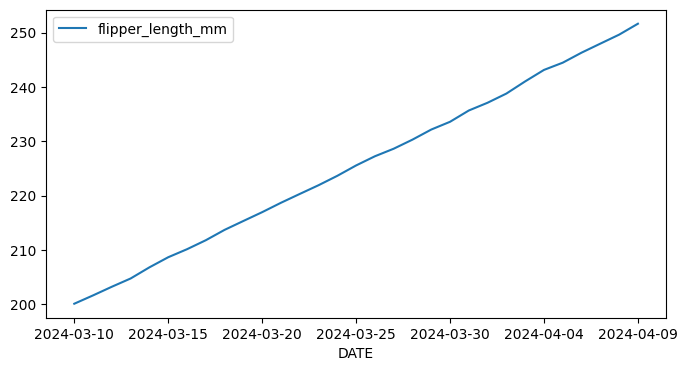

In [78]:
serve['flipper_length_mm'].plot(legend = True, figsize = (8, 4))

<Axes: xlabel='DATE'>

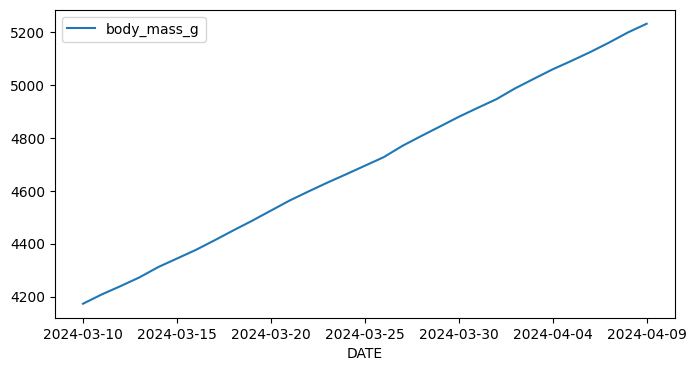

In [79]:
serve['body_mass_g'].plot(legend = True, figsize = (8, 4))

---
## Monitoring With Evaluations

First, look at the evaluation metrics for the most recent days data which has the cumulative change of the past 30 days introduced above.  In this case, the actual known values is known. This may not be possible in many real-world examples where the actual known values are:
- delayed by minutes, hours, days, or even longer
- not always known for all instances
- potentially in a different status that can change over a period of time before being confirmed as final

In reviewing the evaluation for the most recent instances here, the `precision` has dropped and the `log_loss` has increased drastically.  The confusion matrix shows Chinstrap penguins's are now being misclassified much more often than when the model was trained.  

The question becomes "How soon could this have been noticed?".

In [86]:
%%bigquery
SELECT *
FROM ML.EVALUATE (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.production`
        WHERE DATE(feature_timestamp) >= CURRENT_DATE()
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.964286,0.955357,0.957746,0.958034,0.108924,1.0


In [87]:
%%bigquery
SELECT *
FROM ML.CONFUSION_MATRIX (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.production`
        WHERE DATE(feature_timestamp) >= CURRENT_DATE()
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,Adelie_Penguin__Pygoscelis_adeliae_,Chinstrap_penguin__Pygoscelis_antarctica_,Gentoo_penguin__Pygoscelis_papua_
0,Adelie Penguin (Pygoscelis adeliae),30,0,2
1,Chinstrap penguin (Pygoscelis antarctica),0,13,1
2,Gentoo penguin (Pygoscelis papua),0,0,25


### Evaluations: Over Time

In this case, we know the actual identification of the `species` and are measuring the same penguins daily.  Reviewing the evaluations daily could give a good sense of how the model is performing on a daily basis.

The result of the daily evaluations below shows that the log_loss starts to increase immediately and after about a week the first miss-classificaiton occurs and impacts precision/recall/accuracy/f1_score. 

What if the actual values where only known after a lag of days or weeks?  How quickly would evaluations be able to indicate the model's accuracy is possible questionable?  The answer is a different approach - Model Monitoring.  This is covered in the section that follows.

In [82]:
%%bigquery evaluations
DECLARE counter INT64 DEFAULT 30;
DECLARE result STRUCT<precision FLOAT64, recall FLOAT64, accuracy FLOAT64, f1_score FLOAT64, log_loss FLOAT64, roc_auc FLOAT64, eval_date DATE>;
DECLARE results ARRAY<STRUCT<precision FLOAT64, recall FLOAT64, accuracy FLOAT64, f1_score FLOAT64, log_loss FLOAT64, roc_auc FLOAT64, eval_date DATE>> DEFAULT [];
LOOP
    IF counter < 0 THEN LEAVE;
    END IF;
    SET result = (
            SELECT AS STRUCT precision, recall, accuracy, f1_score, log_loss, roc_auc, DATE_SUB(CURRENT_DATE(), INTERVAL counter DAY) AS eval_date
            FROM ML.EVALUATE (
                MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`,
                (
                    SELECT *
                    FROM `statmike-mlops-349915.bqml_model_monitoring.production`
                    WHERE DATE(feature_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL counter DAY)
                )
            )
    );
    SET results = ARRAY_CONCAT(results,[result]);
    SET counter = counter - 1;
END LOOP;
SELECT * FROM UNNEST(results);

Query is running:   0%|          |

Downloading:   0%|          |

In [83]:
evaluations

,precision,recall,accuracy,f1_score,log_loss,roc_auc,eval_date
0,0.977778,0.989583,0.985915,0.983215,0.010123,1.0,2024-03-10
1,0.977778,0.989583,0.985915,0.983215,0.010121,1.0,2024-03-11
2,0.977778,0.989583,0.985915,0.983215,0.010114,1.0,2024-03-12
3,1.000000,1.000000,1.000000,1.000000,0.008777,1.0,2024-03-13
4,1.000000,1.000000,1.000000,1.000000,0.008782,1.0,2024-03-14
5,1.000000,1.000000,1.000000,1.000000,0.007266,1.0,2024-03-15
6,1.000000,1.000000,1.000000,1.000000,0.006503,1.0,2024-03-16
7,1.000000,1.000000,1.000000,1.000000,0.006543,1.0,2024-03-17
8,1.000000,1.000000,1.000000,1.000000,0.006008,1.0,2024-03-18
9,1.000000,1.000000,1.000000,1.000000,0.005983,1.0,2024-03-19


In [84]:
evaluations.set_index('eval_date', inplace = True)

<Axes: title={'center': 'Evaluation Metrics Over Last 30 days'}, xlabel='eval_date'>

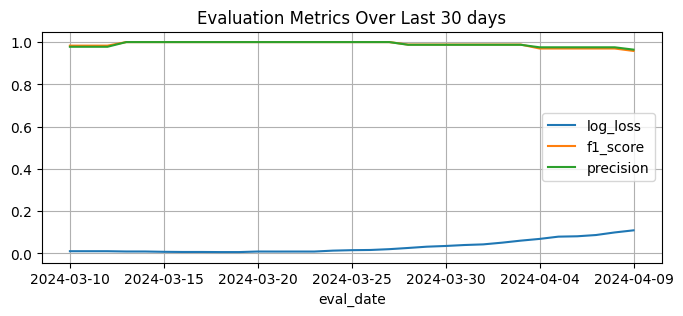

In [85]:
evaluations.plot(y = ['log_loss', 'f1_score', 'precision'], legend = True, title = 'Evaluation Metrics Over Last 30 days', figsize = (8, 3), grid = True)

---
## Model Monitoring

Reviewing model evaluations over time does show a pattern of deterioration in the example above.  But at what point is it actionable?  And what if each days evaluations are relying on actual values that took hours, days, weeks, or even months to be available?  

Model monitoring takes a different approach.  It goes back to the source of the model, each input feature.  These features form a distribution at the input to the model (the training data) and this can be used to compare to over time.  By setting thresholds on these comparisons to the original training data, alerts can be used to notify that a models accuracy *could be* in question.  This comparison to the training data is called **skew** detection.

Similarly, each days values could be compared to the previous days, or weeks values.  These comparisons are referred to as **drift** detection.  

Both of these types of comparisons can be done directly in BigQuery with two functions built for these tasks:
- [`ML.VALIDATE_DATA_SKEW`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-validate-data-skew)
- [`ML.VALIDATE_DATA_DRIFT`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-validate-data-drift)

### Monitoring Skew (Change from training) With `ML.VALIDATE_DATA_SKEW`

In [88]:
%%bigquery
SELECT *
FROM ML.VALIDATE_DATA_SKEW(
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.production`
        WHERE DATE(feature_timestamp) >= CURRENT_DATE()
    )
);

Query is running:   0%|          |

Downloading:   0%|          |

,input,metric,threshold,value,is_anomaly
0,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.3,0.283162,False
1,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.055542,False
2,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.042533,False
3,flipper_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.861126,True
4,island,L_INFTY,0.3,0.008522,False
5,sex,L_INFTY,0.3,0.074685,False


### Monitoring Drift (Change Over Time) With `ML.VALIDATE_DATA_DRIFT`

Compare today to 5 days ago and set the a lower, more sensitive, threshold of `0.03` (default is `0.3`) for all features.

In [90]:
%%bigquery
SELECT *
FROM ML.VALIDATE_DATA_DRIFT(
    (
        SELECT * EXCEPT(feature_timestamp, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.production`
        WHERE DATE(feature_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL 5 DAY)
    ),
    (
        SELECT * EXCEPT(feature_timestamp, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.production`
        WHERE DATE(feature_timestamp) = CURRENT_DATE() 
    ),
    STRUCT(
        0.03 AS categorical_default_threshold,
        0.03 AS numerical_default_threshold
    )
);

Query is running:   0%|          |

Downloading:   0%|          |

,input,metric,threshold,value,is_anomaly
0,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.03,0.061243,True
1,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.03,0.000000,False
2,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.03,0.000000,False
3,flipper_length_mm,JENSEN_SHANNON_DIVERGENCE,0.03,0.149905,True
4,island,L_INFTY,0.03,0.000000,False
5,sex,L_INFTY,0.03,0.000000,False


### Monitoring Skew (Manually) - As Drift from Training Data

Since the `ML.VALIDATE_DATA_DRIFT` is comparing two tables, it could also be used for **skew** by commparing the training data to new data, like todays data:

In [91]:
%%bigquery
SELECT *
FROM ML.VALIDATE_DATA_DRIFT(
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
        WHERE splits = 'TRAIN'
    ),
    (
        SELECT * EXCEPT(feature_timestamp, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.production`
        WHERE DATE(feature_timestamp) = CURRENT_DATE() 
    )
);

Query is running:   0%|          |

Downloading:   0%|          |

,input,metric,threshold,value,is_anomaly
0,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.3,0.283162,False
1,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.055542,False
2,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.042533,False
3,flipper_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.861126,True
4,island,L_INFTY,0.3,0.008522,False
5,sex,L_INFTY,0.3,0.074685,False


---
### Understanding Monitoring Thresholds

---
### Monitoring Feature Attributions

BigQuery ML models, like the deep neural network classifier (`model_type = 'DNN_CLASSIFIER'`) used above, can also serve explanations using the BigQuery function [`ML.EXPLAIN_PREDICT`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).  This function returns feature attributions for each feature used in the model to explain how much contribution was made to the final prediction for a given instance.

**Feature Attributions**

The feature attributions from `ML.EXPLAIN_PREDICT` are [local explanations](https://cloud.google.com/bigquery/docs/xai-overview#local_versus_global_explainability), specific to the instance being predicted.  The attribution values are given for each feature and they add up to the `prediction_value`. In this case the model is a classifier and the `prediction_value` is the logit value (log-odds) of the predicted class.  

#### Serving Feature Attributions

As an example, the following cell gets the feature attributions for a single penguin with for the latest values of the features:

In [92]:
%%bigquery
WITH
    EXPLAIN AS (
        SELECT * EXCEPT(body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm)
        FROM ML.EXPLAIN_PREDICT(
            MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`,
            (
                SELECT * EXCEPT(feature_timestamp, species)
                FROM `statmike-mlops-349915.bqml_model_monitoring.production`
                WHERE DATE(feature_timestamp) = CURRENT_DATE()
                LIMIT 1
            ), 
            STRUCT(10 AS top_k_features)
        )
    ),
    ATTRIBUTIONS AS (
        SELECT * EXCEPT(top_feature_attributions),
        FROM EXPLAIN
        JOIN UNNEST(top_feature_attributions)
    )
SELECT * 
FROM ATTRIBUTIONS

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_species,probability,baseline_prediction_value,prediction_value,approximation_error,feature,attribution
0,Adelie Penguin (Pygoscelis adeliae),0.997036,0.200878,4.401529,0.003698,culmen_length_mm,4.252720
1,Adelie Penguin (Pygoscelis adeliae),0.997036,0.200878,4.401529,0.003698,culmen_depth_mm,2.067140
2,Adelie Penguin (Pygoscelis adeliae),0.997036,0.200878,4.401529,0.003698,body_mass_g,-1.657574
3,Adelie Penguin (Pygoscelis adeliae),0.997036,0.200878,4.401529,0.003698,flipper_length_mm,-0.977632
4,Adelie Penguin (Pygoscelis adeliae),0.997036,0.200878,4.401529,0.003698,sex,0.888969
5,Adelie Penguin (Pygoscelis adeliae),0.997036,0.200878,4.401529,0.003698,island,-0.357439


#### Reviewing Feature Attributions

Get attributions for all penguins:

In [94]:
%%bigquery explain
WITH
    EXPLAIN AS (
        SELECT * EXCEPT(body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm)
        FROM ML.EXPLAIN_PREDICT(
            MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`,
            (
                SELECT * EXCEPT(feature_timestamp, species)
                FROM `statmike-mlops-349915.bqml_model_monitoring.production`
                WHERE DATE(feature_timestamp) = CURRENT_DATE()
            ), 
            STRUCT(10 AS top_k_features)
        )
    ),
    ATTRIBUTIONS AS (
        SELECT * EXCEPT(top_feature_attributions),
        FROM EXPLAIN
        JOIN UNNEST(top_feature_attributions)
    ),
    PIVOT_ATTRIBUTION AS (
        SELECT body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm
        FROM ATTRIBUTIONS PIVOT(MAX(attribution) FOR feature IN ('body_mass_g', 'sex', 'island', 'flipper_length_mm', 'culmen_depth_mm', 'culmen_length_mm'))
    )
SELECT *
FROM PIVOT_ATTRIBUTION

Query is running:   0%|          |

Downloading:   0%|          |

In [95]:
explain.head()

,body_mass_g,sex,island,flipper_length_mm,culmen_depth_mm,culmen_length_mm
0,-1.657574,0.888969,-0.357439,-0.977632,2.067140,4.252720
1,-5.248638,-1.060451,2.278111,-0.389246,1.035935,7.164739
2,-1.441078,0.926956,-0.443435,-1.174914,1.458094,4.760639
3,-2.797626,-1.441296,2.303173,-0.587555,0.648659,6.017699
4,-0.809555,1.118839,-1.101304,-0.638131,5.463074,1.270644


#### Monitor Feature Attributions For Drift with `ML.VALIDATE_DATA_DRIFT`

Compare today to 25 days ago:

In [96]:
%%bigquery
WITH
    EXPLAIN_BASE AS (
        SELECT * EXCEPT(body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm)
        FROM ML.EXPLAIN_PREDICT(
            MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`,
            (
                SELECT * EXCEPT(feature_timestamp, species)
                FROM `statmike-mlops-349915.bqml_model_monitoring.production`
                WHERE DATE(feature_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL 25 DAY)
            ), 
            STRUCT(10 AS top_k_features)
        )
    ),
    ATTRIBUTIONS_BASE AS (
        SELECT * EXCEPT(top_feature_attributions),
        FROM EXPLAIN_BASE
        JOIN UNNEST(top_feature_attributions)
    ),
    PIVOT_ATTRIBUTION_BASE AS (
        SELECT body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm
        FROM ATTRIBUTIONS_BASE PIVOT(MAX(attribution) FOR feature IN ('body_mass_g', 'sex', 'island', 'flipper_length_mm', 'culmen_depth_mm', 'culmen_length_mm'))
    ),
    EXPLAIN_COMP AS (
        SELECT * EXCEPT(body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm)
        FROM ML.EXPLAIN_PREDICT(
            MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_dnn`,
            (
                SELECT * EXCEPT(feature_timestamp, species)
                FROM `statmike-mlops-349915.bqml_model_monitoring.production`
                WHERE DATE(feature_timestamp) = CURRENT_DATE()
            ), 
            STRUCT(10 AS top_k_features)
        )
    ),
    ATTRIBUTIONS_COMP AS (
        SELECT * EXCEPT(top_feature_attributions),
        FROM EXPLAIN_COMP
        JOIN UNNEST(top_feature_attributions)
    ),
    PIVOT_ATTRIBUTION_COMP AS (
        SELECT body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm
        FROM ATTRIBUTIONS_COMP PIVOT(MAX(attribution) FOR feature IN ('body_mass_g', 'sex', 'island', 'flipper_length_mm', 'culmen_depth_mm', 'culmen_length_mm'))
    )
SELECT *
FROM ML.VALIDATE_DATA_DRIFT(
    TABLE PIVOT_ATTRIBUTION_BASE,
    TABLE PIVOT_ATTRIBUTION_COMP
);

Query is running:   0%|          |

Downloading:   0%|          |

,input,metric,threshold,value,is_anomaly
0,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.3,0.535439,True
1,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.169662,False
2,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.044158,False
3,flipper_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.740673,True
4,island,JENSEN_SHANNON_DIVERGENCE,0.3,0.280748,False
5,sex,JENSEN_SHANNON_DIVERGENCE,0.3,0.596198,True


---
### TensorFlow Data Validation (TFDV) In BigQuery

BigQuery offers two functions that bring the power of the TensorFlow's [TFX platform](https://www.tensorflow.org/tfx) with built-in [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started) module directly inside of BigQuery.
- [`ML.TFDV_DESCRIBE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-tfdv-describe) to generate descriptive statistics of any table
- [`ML.TFDV_VALIDATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-tfdv-validate) to compare statistics of two tables

#### Generate Statistics with `ML.TFDV_DESCRIBE`

Generate statistics for any table, in this case the training data features or a timespan of serving data features.  This is like using the TensorFlow's [TFX platform](https://www.tensorflow.org/tfx) with built-in [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started) module's [`tfdv.generate_statistics_from_csv()`](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/generate_statistics_from_csv) method.

The descriptions can be used in comparisons for skew or drift detection with the `ML.TFDV_VALIDATE` function, covered next, as well as in the visualization tool `tfdv.visualize_statistics` also covered below.

In [97]:
%%bigquery train_describe
SELECT *
FROM ML.TFDV_DESCRIBE(
    (
        SELECT * EXCEPT(splits, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
        WHERE splits = 'TRAIN'
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [98]:
train_describe = json.loads(train_describe['dataset_feature_statistics_list'].iloc[0])

In [99]:
train_describe['datasets'][0]['features'][0]

{'name': 'body_mass_g',
 'num_stats': {'common_stats': {'avg_num_values': 1,
   'max_num_values': '1',
   'min_num_values': '1',
   'num_non_missing': '237',
   'num_values_histogram': {'buckets': [{'high_value': 1,
      'low_value': 1,
      'sample_count': 23.8},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.8}],
    'type': 'QUANTILES'},
   'tot_num_values': '237'},
  'histograms': [{'buckets': [{'high_value': 3300,
      'low_value': 2850,
      'sample_count': 23.8},
     {'high_va

In [100]:
%%bigquery today_describe
SELECT *
FROM ML.TFDV_DESCRIBE(
    (
        SELECT * EXCEPT(feature_timestamp, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.production`
        WHERE DATE(feature_timestamp) = CURRENT_DATE()
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [101]:
today_describe = json.loads(today_describe['dataset_feature_statistics_list'].iloc[0])

In [102]:
#today_describe['datasets'][0]['features'][0]

#### Visualize Statistics with `tfdv.visualize_statistics`

Use the [`tfdv.visualize_statistics`](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/visualize_statistics) tool to visualize the generated descriptions and directly compare them.

In [103]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow_data_validation as tfdv
import tensorflow_metadata as tfmd
from google.protobuf import json_format

In [104]:
tfdv.visualize_statistics(
    lhs_statistics = json_format.ParseDict(train_describe, tfmd.proto.statistics_pb2.DatasetFeatureStatisticsList()),
    rhs_statistics = json_format.ParseDict(today_describe, tfmd.proto.statistics_pb2.DatasetFeatureStatisticsList()),
    lhs_name = 'Training Data Stats',
    rhs_name = 'Serving Data Stats - For Today'
)

#### Compare And Detect Anomalies with `ML.TFDV_VALIDATE`

Compare the distribution of any table to a base table and compute distance statistics to detect anomalies.  This is like using the TensorFlow's [TFX platform](https://www.tensorflow.org/tfx) with built-in [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started) module's [validate_statistics api](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/validate_statistics).

These comparison can be made to training data for **skew** detection or previous serving data for **drift** detection.

In [105]:
%%bigquery validate
WITH
    TRAIN AS (
        SELECT * EXCEPT(splits, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
        WHERE splits = 'TRAIN'
    ),
    SERVE AS (
        SELECT * EXCEPT(feature_timestamp, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.production`
        WHERE DATE(feature_timestamp) = CURRENT_DATE()
    )
SELECT ML.TFDV_VALIDATE(
    (SELECT * FROM ML.TFDV_DESCRIBE(TABLE TRAIN)),
    (SELECT * FROM ML.TFDV_DESCRIBE(TABLE SERVE)),
    'DRIFT'
) as validate

Query is running:   0%|          |

Downloading:   0%|          |

In [106]:
validate = json.loads(validate['validate'].iloc[0])

In [107]:
#validate['anomaly_info']

#### Display Anomalies with `tfdv.display_anomalies`

Use the [`tfdv.display_anomalies`](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/display_anomalies) tool to display a table of anomaly detections with descriptions.

In [108]:
del validate['baseline']['generate_legacy_feature_spec']

In [109]:
tfdv.display_anomalies(
    anomalies = json_format.ParseDict(validate, tfmd.proto.anomalies_pb2.Anomalies())
)

,Anomaly short description,Anomaly long description
Feature name,,
'flipper_length_mm',High approximate Jensen-Shannon divergence between current and previous,"The approximate Jensen-Shannon divergence between current and previous is 0.861126 (up to six significant digits), above the threshold 0.3."


---
## Online Monitoring

---
## Continous Monitoring

The methods above can be combined into a job that runs both skew and drift detection.  The jobs can be scheduled or triggered to make the process of model monitoring continous - continous monitoring.  If the model quality can be evaluated with confidence then the automation can even be extended to retrain and update the model for continous training.   

This section shows one of many ways to create a model monitoring job. For models created in BigQuery with BigQuery ML it also shows a retraining action as part of the job when alerts are detected.

These types of jobs could be automated for continous monitoring with one of these methods:
- [BigQuery Scheduled Queries](https://cloud.google.com/bigquery/docs/scheduling-queries)
    - Featured below
- [Dataform](https://cloud.google.com/dataform/docs/quickstart-create-workflow)
- [Workflows](https://cloud.google.com/workflows/docs/tutorials/bigquery-parallel-jobs)
- [Cloud Composer](https://cloud.google.com/composer/docs/data-analytics-googlecloud)
- [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/gcpc-list#bqml_components)

This section will show how to:
- Develop model monitoring jobs:
    - with alerting
    - with alterting and retraining
- Build tables to capture continous monitoring results
- Extend monitoring jobs to BigQuery Scheduled Queries
- Backfill monitoring jobs for a past time period

## Model Monitoring Job: With Alerting And Retraining

Extend the alerting example above:
>A BigQuery SQL job that uses the [procedural language](https://cloud.google.com/bigquery/docs/reference/standard-sql/procedural-language) to execute multiple statements (steps) as a single query.  In this case, monitor skew and drift, detect any feature level anomalies in either and report back the anomalies via a log note with a forced error.

Include retraining of the BigQuery ML model:
In this case the example is simplified to retrain the model and directly implement it as a replacement with `CREATE OR REPLACE MODEL`.  In a production enviornment additional pre/post steps might take place as part of this workflow:
- on skew/drift detection:
    - Prior to retraining:
        - ensure detection is not due to data errors, schema changes, or system changes
    - After retrainning:
        - evaluate the model and compare to current production version
        - conditionally deploy the new version if it is better in any key metrics
        - consider rollout strategies for the retrained model

In [ ]:
%%bigquery
DECLARE drift_anomalies ARRAY<STRING>;
DECLARE drift STRING;
DECLARE skew_anomalies ARRAY<STRING>;
DECLARE skew STRING;

# Monitor Drift
SET drift_anomalies = (
    SELECT ARRAY_AGG(input)
    FROM ML.VALIDATE_DATA_DRIFT(
        (
            SELECT * EXCEPT(splits)
            FROM `statmike-mlops-349915.bqml_model_monitoring.source_split_intro`
            WHERE splits = 'EVAL'
        ),
        (
            SELECT * EXCEPT(splits)
            FROM `statmike-mlops-349915.bqml_model_monitoring.source_split_intro`
            WHERE splits = 'TEST'
        ),
        STRUCT(
            0.03 AS categorical_default_threshold,
            0.03 AS numerical_default_threshold
        )
    )
    WHERE is_anomaly = True
);
IF(ARRAY_LENGTH(drift_anomalies) > 0)
    THEN
        SET drift = CONCAT(
            "Found data drift (", ARRAY_TO_STRING(drift_anomalies, ", "), ")"
        );
    ELSE SET drift = 'No drift detected.';
END IF;

# Monitor Skew
SET skew_anomalies = (
    SELECT ARRAY_AGG(input)
    FROM ML.VALIDATE_DATA_SKEW(
        MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_logistic`,
        (
            SELECT * EXCEPT(splits)
            FROM `statmike-mlops-349915.bqml_model_monitoring.source_split_intro`
            WHERE splits = 'TEST'
        )
    )
    WHERE is_anomaly = True
);
IF(ARRAY_LENGTH(skew_anomalies) > 0)
    THEN
        SET skew = CONCAT(
            "Found data skew (", ARRAY_TO_STRING(skew_anomalies, ", "), ")"
        );
    ELSE SET skew = 'No skew detected.';
END IF;

# Prepare Alert
IF(ARRAY_LENGTH(drift_anomalies) > 0 OR ARRAY_LENGTH(skew_anomalies) > 0)
    THEN
        BEGIN
            DECLARE accuracy FLOAT64;
            DECLARE retrain_accuracy FLOAT64;
            
            # get current models evaluation metrics: accuracy
            SET accuracy = (
                SELECT accuracy
                FROM ML.EVALUATE (
                    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_logistic`
                )
            );
            
            # retrain the model
            CREATE OR REPLACE MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_logistic`
                TRANSFORM(
                    ML.ROBUST_SCALER(body_mass_g) OVER() AS body_mass_g,
                    ML.STANDARD_SCALER(culmen_length_mm) OVER() AS culmen_length_mm,
                    ML.STANDARD_SCALER(culmen_depth_mm) OVER() AS culmen_depth_mm,
                    ML.QUANTILE_BUCKETIZE(flipper_length_mm, 3) OVER() AS flipper_length_mm,
                    ML.IMPUTER(sex, 'most_frequent') OVER() AS sex,
                    ML.IMPUTER(island, 'most_frequent') OVER() AS island,
                    species, split
                )
                OPTIONS(
                    MODEL_TYPE = 'LOGISTIC_REG',
                    INPUT_LABEL_COLS = ['species'],

                    # data specifics
                    DATA_SPLIT_METHOD = 'CUSTOM',
                    DATA_SPLIT_COL = 'split',

                    # model specifics
                    AUTO_CLASS_WEIGHTS = TRUE
                )
            AS
                SELECT * EXCEPT(splits),
                    CASE WHEN splits in ('TRAIN', 'TEST') THEN FALSE
                    ELSE TRUE END AS split
                FROM `statmike-mlops-349915.bqml_model_monitoring.source_split_intro`
            ;
            
            # get retrained models evaluation metrics: accuracy
            SET retrain_accuracy = (
                SELECT accuracy
                FROM ML.EVALUATE (
                    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_logistic`
                )
            );

            SELECT ERROR(
                CONCAT(
                    "\nMonitoring Report:",
                    "\n\t", drift,
                    "\n\t", skew,
                    "\nThe Model was retrained:",
                    "\n\taccuracy before retraining: ", accuracy,
                    "\n\taccuracy after retraining: ", retrain_accuracy
                )
            );
        END;
END IF;

---
---
---
---
---

---
## Continous Model Monitoring

By initiating model monitoring on a regular basis the results of anomaly detection can be turned into actions, like:
- trigger a person to review a model
- automatically trigger the retraining of the model: continous training

Monitoring could be scheduled or triggered:
- scheduled to run hourly, daily, weekly based on the volume of prediction requests expected
- triggered to run based on a volume of requests

By using SQL to do monitoring queries it opens up many options for automation of this process:
- Cloud Workflows
    - Including with Dataform
- Cloud Composer
    - Including with Dataform
- Scheduled Queries

This section shows an easy way to get started with automation using scheduled queries and Cloud Logging to trigger email notificaitons.

### Build Monitoring Tables

Create BigQuery tables to hold the results:
- Daily Skew Monitoring
- Daily Drift Monitoring
- Results of `TFDV_DESCRIBE` for each day

From the serving data for the features, calculate the timestamp of the earliest day.  To get all the features values from thid day also shift to the start of the next calendar day.

In [391]:
%%bigquery
SELECT TIMESTAMP_ADD(TIMESTAMP_TRUNC(MIN(feature_timestamp), DAY, "UTC"), INTERVAL 1 DAY)
FROM `statmike-mlops-349915.bqml_model_monitoring.production_features`

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,2024-02-20 00:00:00+00:00


#### Create Table: `monitoring_daily_skew`

Columns: `Model | Time | input | metric | threshold | value | is_anomaly`

Initialize the table with results from the first day of model deployment.

In [394]:
%%bigquery
DECLARE FIRST_SERVE_DATE TIMESTAMP;
SET FIRST_SERVE_DATE = (
    SELECT TIMESTAMP_ADD(TIMESTAMP_TRUNC(MIN(feature_timestamp), DAY, "UTC"), INTERVAL 1 DAY)
    FROM `statmike-mlops-349915.bqml_model_monitoring.production_features`);

CREATE OR REPLACE TABLE `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_skew` AS
    WITH
        BASE_TABLE AS (
            SELECT *
            FROM ML.TRANSFORM(
                MODEL `statmike-mlops-349915.bqml_model_monitoring.feature_engineering`,
                (
                    SELECT * EXCEPT(splits, species)
                    FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
                    WHERE splits = 'TRAIN'
                )
            )   
        ),
        COMPARE_TABLE AS (
            SELECT * EXCEPT(entity_id, feature_timestamp, species)
            FROM ML.FEATURES_AT_TIME(
                TABLE `statmike-mlops-349915.bqml_model_monitoring.production_features`,
                time => FIRST_SERVE_DATE,
                num_rows => 1,
                ignore_feature_nulls => TRUE
            )     
        )
    SELECT
        'statmike-mlops-349915.bqml_model_monitoring.feature_engineering' AS Model,
        FIRST_SERVE_DATE AS Time,
        *
    FROM ML.VALIDATE_DATA_DRIFT(
        TABLE BASE_TABLE,
        TABLE COMPARE_TABLE
    );

INSERT `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_skew`
    WITH
        BASE_TABLE AS (
            SELECT *
            FROM ML.TRANSFORM(
                MODEL `statmike-mlops-349915.bqml_model_monitoring.feature_engineering`,
                (
                    SELECT * EXCEPT(splits, species)
                    FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
                    WHERE splits = 'TRAIN'
                )
            )   
        ),
        COMPARE_TABLE AS (
            SELECT * EXCEPT(entity_id, feature_timestamp, species)
            FROM ML.FEATURES_AT_TIME(
                TABLE `statmike-mlops-349915.bqml_model_monitoring.production_features`,
                time => TIMESTAMP_ADD(FIRST_SERVE_DATE, INTERVAL 1 DAY),
                num_rows => 1,
                ignore_feature_nulls => TRUE
            )     
        )
    SELECT
        'statmike-mlops-349915.bqml_model_monitoring.feature_engineering' AS Model,
        TIMESTAMP_ADD(FIRST_SERVE_DATE, INTERVAL 1 DAY) AS Time,
        *
    FROM ML.VALIDATE_DATA_DRIFT(
        TABLE BASE_TABLE,
        TABLE COMPARE_TABLE
    );

Query is running:   0%|          |

""


In [395]:
%%bigquery
SELECT *
FROM `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_skew`

Query is running:   0%|          |

Downloading:   0%|          |

,Model,Time,input,metric,threshold,value,is_anomaly
0,statmike-mlops-349915.bqml_central_monitoring....,2024-02-21 00:00:00+00:00,flipper_length_mm,L_INFTY,0.3,0.031913,False
1,statmike-mlops-349915.bqml_central_monitoring....,2024-02-21 00:00:00+00:00,island,L_INFTY,0.3,0.371760,True
2,statmike-mlops-349915.bqml_central_monitoring....,2024-02-21 00:00:00+00:00,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.089222,False
3,statmike-mlops-349915.bqml_central_monitoring....,2024-02-21 00:00:00+00:00,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.3,0.819610,True
4,statmike-mlops-349915.bqml_central_monitoring....,2024-02-21 00:00:00+00:00,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.162937,False
5,statmike-mlops-349915.bqml_central_monitoring....,2024-02-21 00:00:00+00:00,sex,L_INFTY,0.3,0.376198,True
6,statmike-mlops-349915.bqml_central_monitoring....,2024-02-20 00:00:00+00:00,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.089222,False
7,statmike-mlops-349915.bqml_central_monitoring....,2024-02-20 00:00:00+00:00,sex,L_INFTY,0.3,0.032252,False
8,statmike-mlops-349915.bqml_central_monitoring....,2024-02-20 00:00:00+00:00,flipper_length_mm,L_INFTY,0.3,0.060082,False
9,statmike-mlops-349915.bqml_central_monitoring....,2024-02-20 00:00:00+00:00,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.162937,False


#### Create Table: `monitoring_daily_drift`

Columns: `Model | Compare_Time | Time | input | metric | threshold | value | is_anomaly`

Initialize the table with results from the drift from the second day of model deployment.

In [396]:
%%bigquery
DECLARE FIRST_SERVE_DATE TIMESTAMP;
SET FIRST_SERVE_DATE = (
    SELECT TIMESTAMP_ADD(TIMESTAMP_TRUNC(MIN(feature_timestamp), DAY, "UTC"), INTERVAL 1 DAY)
    FROM `statmike-mlops-349915.bqml_model_monitoring.production_features`);

CREATE OR REPLACE TABLE `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_drift` AS
    WITH
        BASE_TABLE AS (
            SELECT * EXCEPT(entity_id, feature_timestamp, species)
            FROM ML.FEATURES_AT_TIME(
                TABLE `statmike-mlops-349915.bqml_model_monitoring.production_features`,
                time => FIRST_SERVE_DATE,
                num_rows => 1,
                ignore_feature_nulls => TRUE
            )   
        ),
        COMPARE_TABLE AS (
            SELECT * EXCEPT(entity_id, feature_timestamp, species)
            FROM ML.FEATURES_AT_TIME(
                TABLE `statmike-mlops-349915.bqml_model_monitoring.production_features`,
                time => TIMESTAMP_ADD(FIRST_SERVE_DATE, INTERVAL 1 DAY),
                num_rows => 1,
                ignore_feature_nulls => TRUE
            )     
        )
    SELECT
        'statmike-mlops-349915.bqml_model_monitoring.feature_engineering' AS Model,
        FIRST_SERVE_DATE AS Compare_Time,
        TIMESTAMP_ADD(FIRST_SERVE_DATE, INTERVAL 1 DAY) AS Time,
        *
    FROM ML.VALIDATE_DATA_DRIFT(
        TABLE BASE_TABLE,
        TABLE COMPARE_TABLE,
        STRUCT(
            0.03 AS categorical_default_threshold,
            0.03 AS numerical_default_threshold
        )
    );

Query is running:   0%|          |

""


In [397]:
%%bigquery
SELECT *
FROM `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_drift`

Query is running:   0%|          |

Downloading:   0%|          |

,Model,Compare_Time,Time,input,metric,threshold,value,is_anomaly
0,statmike-mlops-349915.bqml_central_monitoring....,2024-02-20 00:00:00+00:00,2024-02-21 00:00:00+00:00,island,L_INFTY,0.03,0.380282,True
1,statmike-mlops-349915.bqml_central_monitoring....,2024-02-20 00:00:00+00:00,2024-02-21 00:00:00+00:00,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.03,0.006038,False
2,statmike-mlops-349915.bqml_central_monitoring....,2024-02-20 00:00:00+00:00,2024-02-21 00:00:00+00:00,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.03,0.000000,False
3,statmike-mlops-349915.bqml_central_monitoring....,2024-02-20 00:00:00+00:00,2024-02-21 00:00:00+00:00,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.03,0.000000,False
4,statmike-mlops-349915.bqml_central_monitoring....,2024-02-20 00:00:00+00:00,2024-02-21 00:00:00+00:00,sex,L_INFTY,0.03,0.408451,True
5,statmike-mlops-349915.bqml_central_monitoring....,2024-02-20 00:00:00+00:00,2024-02-21 00:00:00+00:00,flipper_length_mm,L_INFTY,0.03,0.028169,False


#### Create Table: `monitoring_daily_tfdv_describe`

Columns: `Model | Time | tfdv_describe`

Initialize the table with results from the first two days of model deployment.

In [399]:
%%bigquery
DECLARE FIRST_SERVE_DATE TIMESTAMP;
SET FIRST_SERVE_DATE = (
    SELECT TIMESTAMP_ADD(TIMESTAMP_TRUNC(MIN(feature_timestamp), DAY, "UTC"), INTERVAL 1 DAY)
    FROM `statmike-mlops-349915.bqml_model_monitoring.production_features`);

CREATE OR REPLACE TABLE `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_tfdv_describe` AS
    SELECT
        'statmike-mlops-349915.bqml_model_monitoring.feature_engineering' AS Model,
        FIRST_SERVE_DATE AS Time,
        dataset_feature_statistics_list AS tfdv_describe
    FROM ML.TFDV_DESCRIBE(
        (
            SELECT * EXCEPT(entity_id, feature_timestamp, species)
            FROM ML.FEATURES_AT_TIME(
                TABLE `statmike-mlops-349915.bqml_model_monitoring.production_features`,
                time => FIRST_SERVE_DATE,
                num_rows => 1,
                ignore_feature_nulls => TRUE
            ) 
        )
    );
    
INSERT `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_tfdv_describe`
    SELECT
        'statmike-mlops-349915.bqml_model_monitoring.feature_engineering' AS Model,
        TIMESTAMP_ADD(FIRST_SERVE_DATE, INTERVAL 1 DAY) AS Time,
        dataset_feature_statistics_list AS tfdv_describe
    FROM ML.TFDV_DESCRIBE(
        (
            SELECT * EXCEPT(entity_id, feature_timestamp, species)
            FROM ML.FEATURES_AT_TIME(
                TABLE `statmike-mlops-349915.bqml_model_monitoring.production_features`,
                time => TIMESTAMP_ADD(FIRST_SERVE_DATE, INTERVAL 1 DAY),
                num_rows => 1,
                ignore_feature_nulls => TRUE
            ) 
        )
    );

Query is running:   0%|          |

""


In [400]:
%%bigquery
SELECT *
FROM `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_tfdv_describe`

Query is running:   0%|          |

Downloading:   0%|          |

,Model,Time,tfdv_describe
0,statmike-mlops-349915.bqml_central_monitoring....,2024-02-20 00:00:00+00:00,"{""datasets"":[{""features"":[{""name"":""body_mass_g..."
1,statmike-mlops-349915.bqml_central_monitoring....,2024-02-21 00:00:00+00:00,"{""datasets"":[{""features"":[{""name"":""body_mass_g..."


#### Create Table: `model_train_tfdv_describe`

Columns: `Model | tfdv_describe`

Add training dataset statistics to an overall table:

In [402]:
%%bigquery
CREATE OR REPLACE TABLE `statmike-mlops-349915.bqml_model_monitoring.model_train_tfdv_describe` AS
    SELECT
        'statmike-mlops-349915.bqml_model_monitoring.feature_engineering' AS Model,
        dataset_feature_statistics_list AS tfdv_describe
    FROM ML.TFDV_DESCRIBE(
        (
            SELECT *
            FROM ML.TRANSFORM(
                MODEL `statmike-mlops-349915.bqml_model_monitoring.feature_engineering`,
                (
                    SELECT * EXCEPT(splits, species)
                    FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
                    WHERE splits = 'TRAIN'
                )
            )
        )
    );

Query is running:   0%|          |

""


In [403]:
%%bigquery
SELECT *
FROM `statmike-mlops-349915.bqml_model_monitoring.model_train_tfdv_describe`

Query is running:   0%|          |

Downloading:   0%|          |

,Model,tfdv_describe
0,statmike-mlops-349915.bqml_central_monitoring....,"{""datasets"":[{""features"":[{""name"":""body_mass_g..."


### Anomaly Alerting

When scheduling the daily monitoring below, alerting for anomalies will be triggered by checking for anomaly values and if present throw an error using the [`ERROR` debugging function](https://cloud.google.com/bigquery/docs/reference/standard-sql/debugging_functions#error).

Test this here:

In [406]:
%%bigquery
SELECT
    CASE
        WHEN is_anomaly = True THEN ERROR(CONCAT('Found a model monitoring skew anomaly for feature = ', input, ' on ', time, ' for model = ', model))
    END AS anomaly_catcher
FROM `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_skew`

Executing query with job ID: 19b3637c-5677-450d-82ac-a0107f073401
Query executing: 0.55s


ERROR:
 400 Found a model monitoring skew anomaly for feature = island on 2024-02-21 00:00:00+00 for model = statmike-mlops-349915.bqml_central_monitoring.feature_engineering

Location: US
Job ID: 19b3637c-5677-450d-82ac-a0107f073401



In [407]:
%%bigquery
SELECT
    CASE
        WHEN is_anomaly = True THEN ERROR(CONCAT('Found a model monitoring drift anomaly for feature = ', input, ' on ', time, ' for model = ', model))
    END AS anomaly_catcher
FROM `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_drift`

Executing query with job ID: ba261466-0a49-4738-8e9d-3ec7dc23b223
Query executing: 0.56s


ERROR:
 400 Found a model monitoring drift anomaly for feature = island on 2024-02-21 00:00:00+00 for model = statmike-mlops-349915.bqml_central_monitoring.feature_engineering

Location: US
Job ID: ba261466-0a49-4738-8e9d-3ec7dc23b223



### Scheduled Query: Daily Monitoring

Setup a scheduled query to:
- run a skew monitoring query and insert results into `monitoring_daily_skew`
- run a drift monitoring query and insert results into `monitoring_daily_drift`
- run a `TFDV_DESCRIBE` query and insert result into `monitoring_daily_tfdv_describe`
- run a detection query to look for drift and/or skew anomalies for today and use the [`ERROR` debugging function](https://cloud.google.com/bigquery/docs/reference/standard-sql/debugging_functions#error) to alert when `is_anomaly = True`.
- setup notificaiton emails for when errors are detected


In [426]:
%%writefile bq_monitoring.sql

# monitor skew
MERGE `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_skew` T
USING (
    WITH
        BASE_TABLE AS (
            SELECT *
            FROM ML.TRANSFORM(
                MODEL `statmike-mlops-349915.bqml_model_monitoring.feature_engineering`,
                (
                    SELECT * EXCEPT(splits, species)
                    FROM `statmike-mlops-349915.bqml_model_monitoring.source_split`
                    WHERE splits = 'TRAIN'
                )
            )   
        ),
        COMPARE_TABLE AS (
            SELECT * EXCEPT(entity_id, feature_timestamp, species)
            FROM ML.FEATURES_AT_TIME(
                TABLE `statmike-mlops-349915.bqml_model_monitoring.production_features`,
                time => TIMESTAMP_TRUNC(@run_time, DAY, "UTC"),
                num_rows => 1,
                ignore_feature_nulls => TRUE
            )     
        )
    SELECT
        'statmike-mlops-349915.bqml_model_monitoring.feature_engineering' AS Model,
        TIMESTAMP_TRUNC(@run_time, DAY, "UTC") AS Time,
        *
    FROM ML.VALIDATE_DATA_DRIFT(
        TABLE BASE_TABLE,
        TABLE COMPARE_TABLE
    )
) S
ON S.Model = T.Model AND S.Time = T.Time AND S.input = T.input
WHEN NOT MATCHED THEN
    INSERT ROW;

# monitor drift
MERGE `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_drift` T
USING (
    WITH
        BASE_TABLE AS (
            SELECT * EXCEPT(entity_id, feature_timestamp, species)
            FROM ML.FEATURES_AT_TIME(
                TABLE `statmike-mlops-349915.bqml_model_monitoring.production_features`,
                time => TIMESTAMP_SUB(TIMESTAMP_TRUNC(@run_time, DAY, "UTC"), INTERVAL 1 DAY),
                num_rows => 1,
                ignore_feature_nulls => TRUE
            )   
        ),
        COMPARE_TABLE AS (
            SELECT * EXCEPT(entity_id, feature_timestamp, species)
            FROM ML.FEATURES_AT_TIME(
                TABLE `statmike-mlops-349915.bqml_model_monitoring.production_features`,
                time => TIMESTAMP_TRUNC(@run_time, DAY, "UTC"),
                num_rows => 1,
                ignore_feature_nulls => TRUE
            )     
        )
    SELECT
        'statmike-mlops-349915.bqml_model_monitoring.feature_engineering' AS Model,
        TIMESTAMP_SUB(TIMESTAMP_TRUNC(@run_time, DAY, "UTC"), INTERVAL 1 DAY) AS Compare_Time,
        TIMESTAMP_TRUNC(@run_time, DAY, "UTC") AS Time,
        *
    FROM ML.VALIDATE_DATA_DRIFT(
        TABLE BASE_TABLE,
        TABLE COMPARE_TABLE,
        STRUCT(
            0.03 AS categorical_default_threshold,
            0.03 AS numerical_default_threshold
        )
    )
) S
ON S.Model = T.Model AND S.Time = T.Time AND S.input = T.input
WHEN NOT MATCHED THEN
    INSERT ROW;
    
# tfdv_describe for today
MERGE `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_tfdv_describe` T
USING (
    SELECT
        'statmike-mlops-349915.bqml_model_monitoring.feature_engineering' AS Model,
        TIMESTAMP_TRUNC(@run_time, DAY, "UTC") AS Time,
        dataset_feature_statistics_list AS tfdv_describe
    FROM ML.TFDV_DESCRIBE(
        (
            SELECT * EXCEPT(entity_id, feature_timestamp, species)
            FROM ML.FEATURES_AT_TIME(
                TABLE `statmike-mlops-349915.bqml_model_monitoring.production_features`,
                time => TIMESTAMP_TRUNC(@run_time, DAY, "UTC"),
                num_rows => 1,
                ignore_feature_nulls => TRUE
            ) 
        )
    )
) S
ON S.Model = T.Model AND S.Time = T.Time
WHEN NOT MATCHED THEN
    INSERT ROW;
    
# check for skew anomalies
SELECT
    CASE
        WHEN is_anomaly = True THEN ERROR(CONCAT('Found a model monitoring skew anomaly for feature = ', input, ' on ', time, ' for model = ', model))
    END AS anomaly_catcher
FROM `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_skew`
WHERE time = TIMESTAMP_TRUNC(@run_time, DAY, "UTC");
    
# check for drift anomalies
SELECT
    CASE
        WHEN is_anomaly = True THEN ERROR(CONCAT('Found a model monitoring drift anomaly for feature = ', input, ' on ', time, ' for model = ', model))
    END AS anomaly_catcher
FROM `statmike-mlops-349915.bqml_model_monitoring.monitoring_daily_drift`
WHERE time = TIMESTAMP_TRUNC(@run_time, DAY, "UTC");


Overwriting bq_monitoring.sql


### Backfill With Manual Run on Historical Dates

Run the scheduled query to fill in data for all days prior today today.

### Email Notificaitons

### Review Detections

---
# TODO

- at model creation: make note about all the ways to use BQML: create, remote, import, or just log predictions to BQ

- model register to Vertex
    - setup endpoint with logging
    - show shift and drift against both endpoint and batch
- Draw serving architecture and explain it with a full section